In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
from pymc_marketing.mmm import MMM
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
import arviz as az
az.style.use("arviz-darkgrid")
from scipy.stats import beta, gamma, halfnorm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data generating process

In [5]:
def data_generator(spend_rand_change, true_coef):
    
    # Parameter for adding random variation to marketing spend
    spend_rand_change = spend_rand_change

    # Parameters for initial components
    start_date = "2018-01-01"
    periods = 365 * 3  # Daily data for three years
    trend = 0.01  # Linear trend component
    seasonal_amplitude = 5  # Amplitude of the seasonal component
    seasonal_period = 30.44 # Monthly
    noise_level = 5  # Level of random noise

    # Create initial components
    time = np.arange(periods)
    date_range = pd.date_range(start=start_date, periods=periods)
    trend_component = trend * time
    seasonal_component = seasonal_amplitude * np.sin(2 * np.pi * time / seasonal_period)
    noise_component = noise_level * np.random.randn(periods)
    demand = 100 + trend_component + seasonal_component + noise_component

    # Initial demand series
    df = pd.DataFrame({'date': date_range, 'demand': demand})

    # Create demand forecast
    df['demand_forecast'] = df['demand'] * np.random.uniform(0.95, 1.05, len(df))

    # Create social media and tv spend
    df['social_spend'] = df['demand_forecast'] * 10 * np.random.uniform(1 - spend_rand_change, 1 + spend_rand_change, len(df))
    df['tv_spend'] = df['demand_forecast'] * 20 * np.random.uniform(1 - spend_rand_change, 1 + spend_rand_change, len(df))
    df['total_spend'] = df['social_spend'] + df['tv_spend']

    # Create sales
    df['sales'] = df['demand'] * true_coef[0] + df['social_spend'] * true_coef[1] + df['tv_spend'] * true_coef[2]
    sales_noise = 0.01 * df['sales'] * np.random.randn(len(df))
    df['sales'] = df['sales'] + sales_noise
    
    return df

In [6]:
features = [
    "demand",
    "social_spend",
    "tv_spend"
]

target = "sales"

true_coef = [0.35, 0.15, 0.05]

In [46]:
np.random.seed(40)

df = data_generator(0.00, true_coef)

In [47]:
df

,date,demand,demand_forecast,social_spend,tv_spend,total_spend,sales
0,2018-01-01,96.962262,94.410755,944.107546,1888.215093,2832.322639,271.131140
1,2018-01-02,100.404066,104.311174,1043.111739,2086.223479,3129.335218,293.516768
2,2018-01-03,98.602958,101.184808,1011.848078,2023.696156,3035.544234,285.972011
3,2018-01-04,107.575641,103.904327,1039.043274,2078.086548,3117.129822,299.163522
4,2018-01-05,94.492933,90.788996,907.889961,1815.779922,2723.669884,257.021151
...,...,...,...,...,...,...,...
1090,2020-12-26,110.701326,115.731821,1157.318211,2314.636423,3471.954634,328.021899
1091,2020-12-27,109.169646,107.421678,1074.216777,2148.433554,3222.650331,308.356768
1092,2020-12-28,95.855767,92.446661,924.466610,1848.933220,2773.399830,261.355745
1093,2020-12-29,109.057176,105.671666,1056.716656,2113.433312,3170.149968,297.535658


In [48]:
date_col = "date"

y_col = "sales"

channel_cols = ["social_spend",
                "tv_spend"]

control_cols = ["demand"]

X = df[[date_col] + channel_cols + control_cols]
y = df[y_col]

In [77]:
# calculate contribution
true_contributions = [round(np.sum(X["demand"] * true_coef[0]) / np.sum(y), 2), 
                      round(np.sum(X["social_spend"] * true_coef[1]) / np.sum(y), 2), 
                      round(np.sum(X["tv_spend"] * true_coef[2]) / np.sum(y), 2)]
true_contributions

[0.12, 0.53, 0.35]

# Model training - Default config

### Default priors

In [49]:
mmm_default = MMM(
    adstock="geometric",
    saturation="logistic",
    date_column=date_col,
    channel_columns=channel_cols,
    control_columns=control_cols,
    adstock_max_lag=4,
    yearly_seasonality=2,
)

mmm_default.default_model_config

{'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},
 'gamma_control': {'dist': 'Normal',
  'kwargs': {'mu': 0, 'sigma': 2},
  'dims': 'control'},
 'gamma_fourier': {'dist': 'Laplace',
  'kwargs': {'mu': 0, 'b': 1},
  'dims': 'fourier_mode'},
 'adstock_alpha': {'dist': 'Beta',
  'kwargs': {'alpha': 1, 'beta': 3},
  'dims': 'channel'},
 'saturation_lam': {'dist': 'Gamma',
  'kwargs': {'alpha': 3, 'beta': 1},
  'dims': 'channel'},
 'saturation_beta': {'dist': 'HalfNormal',
  'kwargs': {'sigma': 2},
  'dims': 'channel'}}

### Saturation beta

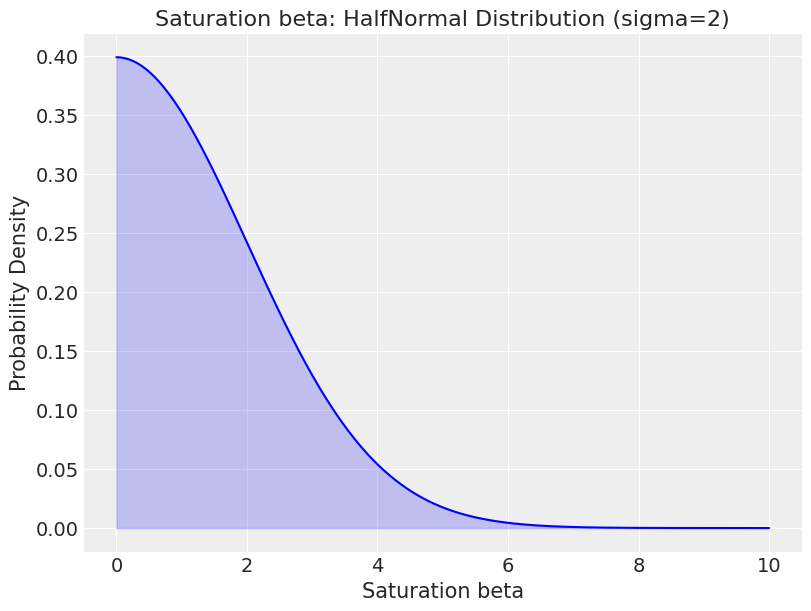

In [50]:
sigma = 2

x1 = np.linspace(0, 10, 1000)
y1 = halfnorm.pdf(x1, scale=sigma)

plt.figure(figsize=(8, 6))
plt.plot(x1, y1, 'b-')
plt.fill_between(x1, y1, alpha=0.2, color='blue')
plt.title('Saturation beta: HalfNormal Distribution (sigma=2)')
plt.xlabel('Saturation beta')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


### Setting priors

In [51]:
total_spend_per_channel = df[channel_cols].sum(axis=0)
spend_share = total_spend_per_channel / total_spend_per_channel.sum()
spend_share

social_spend    0.333333
tv_spend        0.666667
dtype: float64

In [52]:
n_channels = df[channel_cols].shape[1]
prior_sigma = n_channels * spend_share.to_numpy()
prior_sigma

array([0.66666667, 1.33333333])

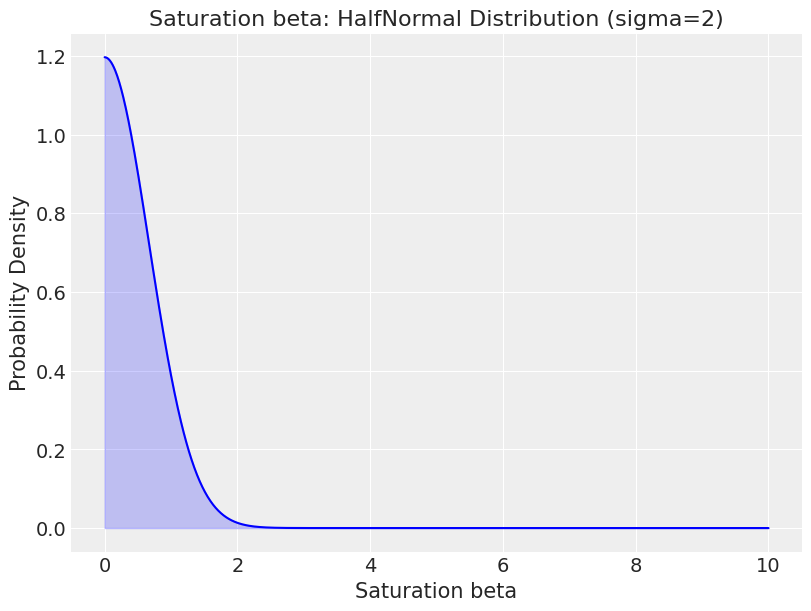

In [54]:
sigma = prior_sigma[0]

x1 = np.linspace(0, 10, 1000)
y1 = halfnorm.pdf(x1, scale=sigma)

plt.figure(figsize=(8, 6))
plt.plot(x1, y1, 'b-')
plt.fill_between(x1, y1, alpha=0.2, color='blue')
plt.title('Saturation beta: HalfNormal Distribution (sigma=2)')
plt.xlabel('Saturation beta')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


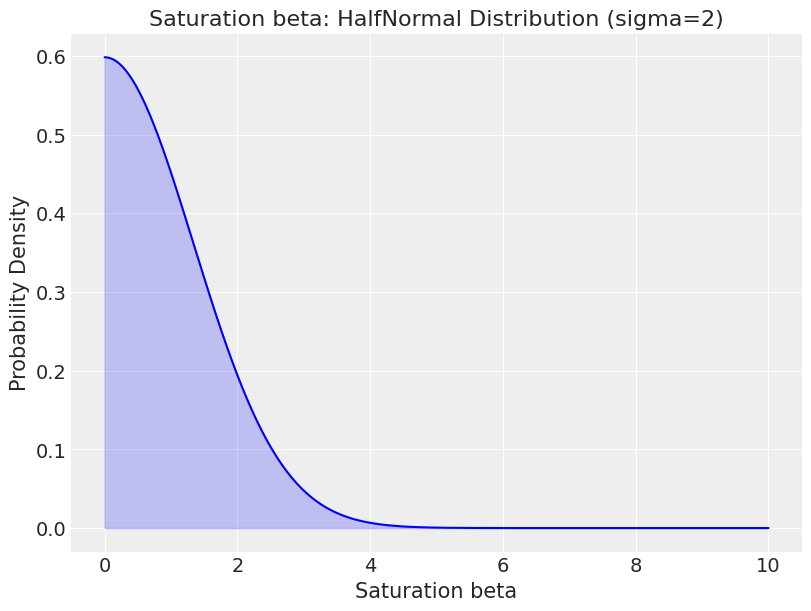

In [56]:
sigma = prior_sigma[1]

x1 = np.linspace(0, 10, 1000)
y1 = halfnorm.pdf(x1, scale=sigma)

plt.figure(figsize=(8, 6))
plt.plot(x1, y1, 'b-')
plt.fill_between(x1, y1, alpha=0.2, color='blue')
plt.title('Saturation beta: HalfNormal Distribution (sigma=2)')
plt.xlabel('Saturation beta')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [ ]:
# why do we multiply the spend share by number of channels?

In [57]:
my_model_config = {'saturation_beta': {'dist': 'HalfNormal', 'kwargs': {'sigma': prior_sigma}}}

In [58]:
mmm_priors = MMM(
    model_config=my_model_config,
    adstock="geometric",
    saturation="logistic",
    date_column=date_col,
    channel_columns=channel_cols,
    control_columns=control_cols,
    adstock_max_lag=4,
    yearly_seasonality=2,
)

mmm_priors.default_model_config

{'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},
 'gamma_control': {'dist': 'Normal',
  'kwargs': {'mu': 0, 'sigma': 2},
  'dims': 'control'},
 'gamma_fourier': {'dist': 'Laplace',
  'kwargs': {'mu': 0, 'b': 1},
  'dims': 'fourier_mode'},
 'adstock_alpha': {'dist': 'Beta',
  'kwargs': {'alpha': 1, 'beta': 3},
  'dims': 'channel'},
 'saturation_lam': {'dist': 'Gamma',
  'kwargs': {'alpha': 3, 'beta': 1},
  'dims': 'channel'},
 'saturation_beta': {'dist': 'HalfNormal',
  'kwargs': {'sigma': array([0.66666667, 1.33333333])},
  'dims': 'channel'}}

### Model training default

In [59]:
mmm_default.fit(X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1927 seconds.
There were 307 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

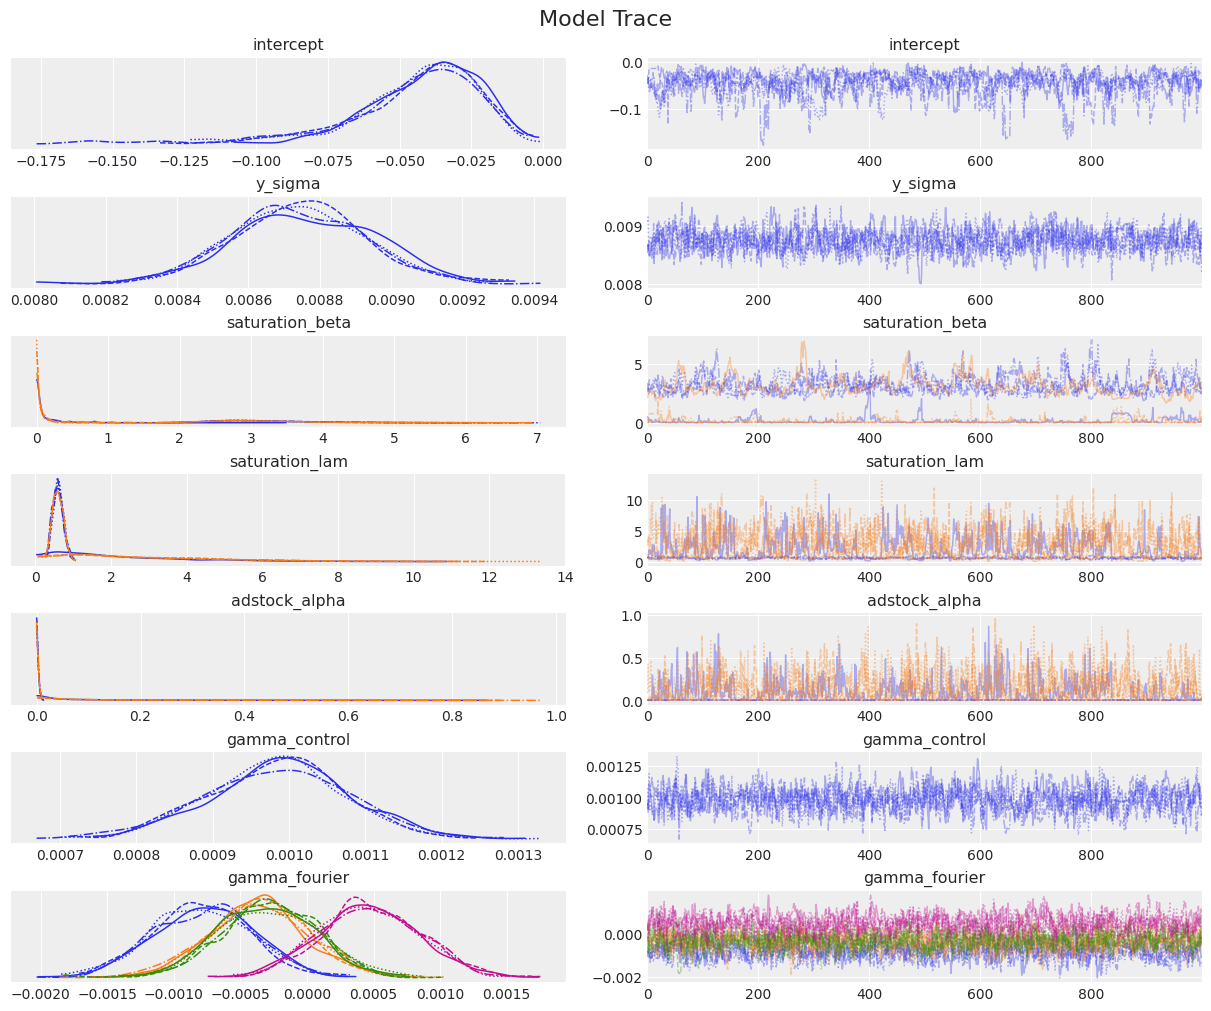

In [60]:
_ = az.plot_trace(
    data=mmm_default.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

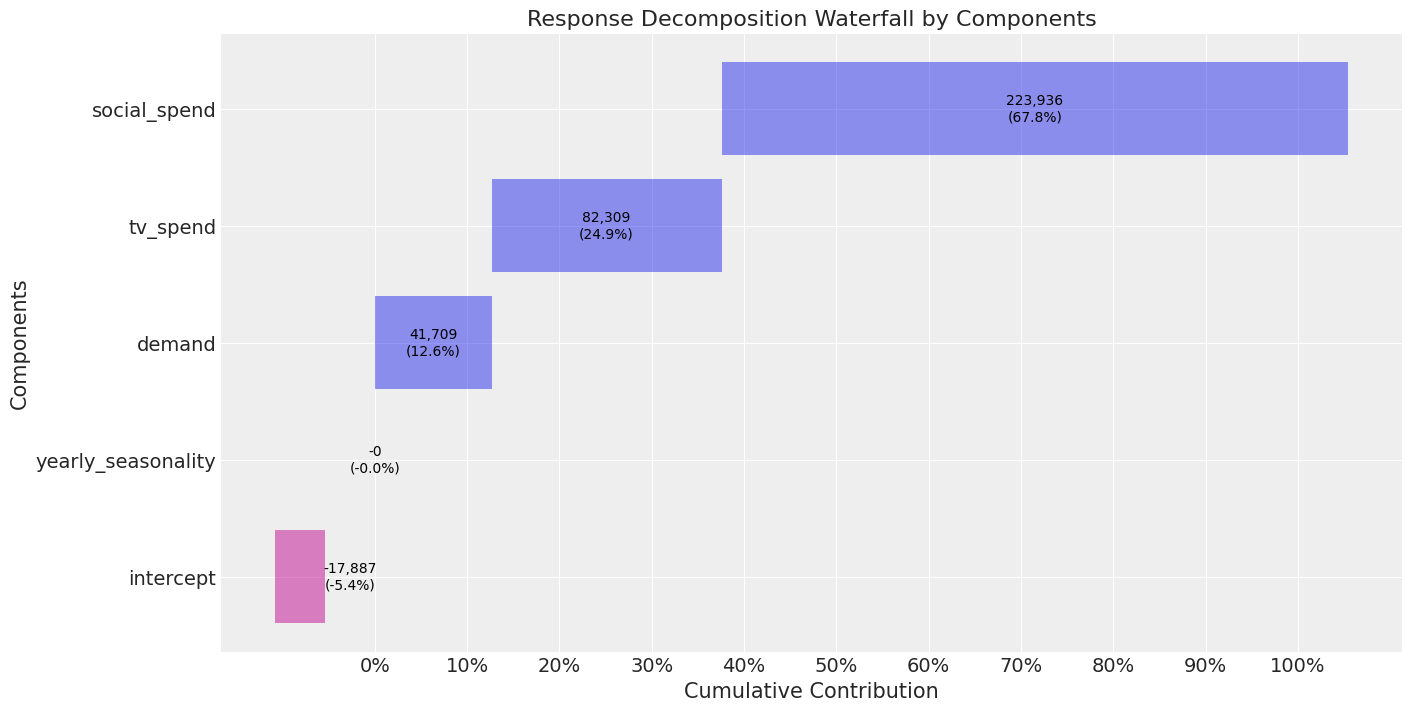

In [61]:
mmm_default.plot_waterfall_components_decomposition();

### Model training - Custom

In [62]:
mmm_priors.fit(X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2981 seconds.
There were 342 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

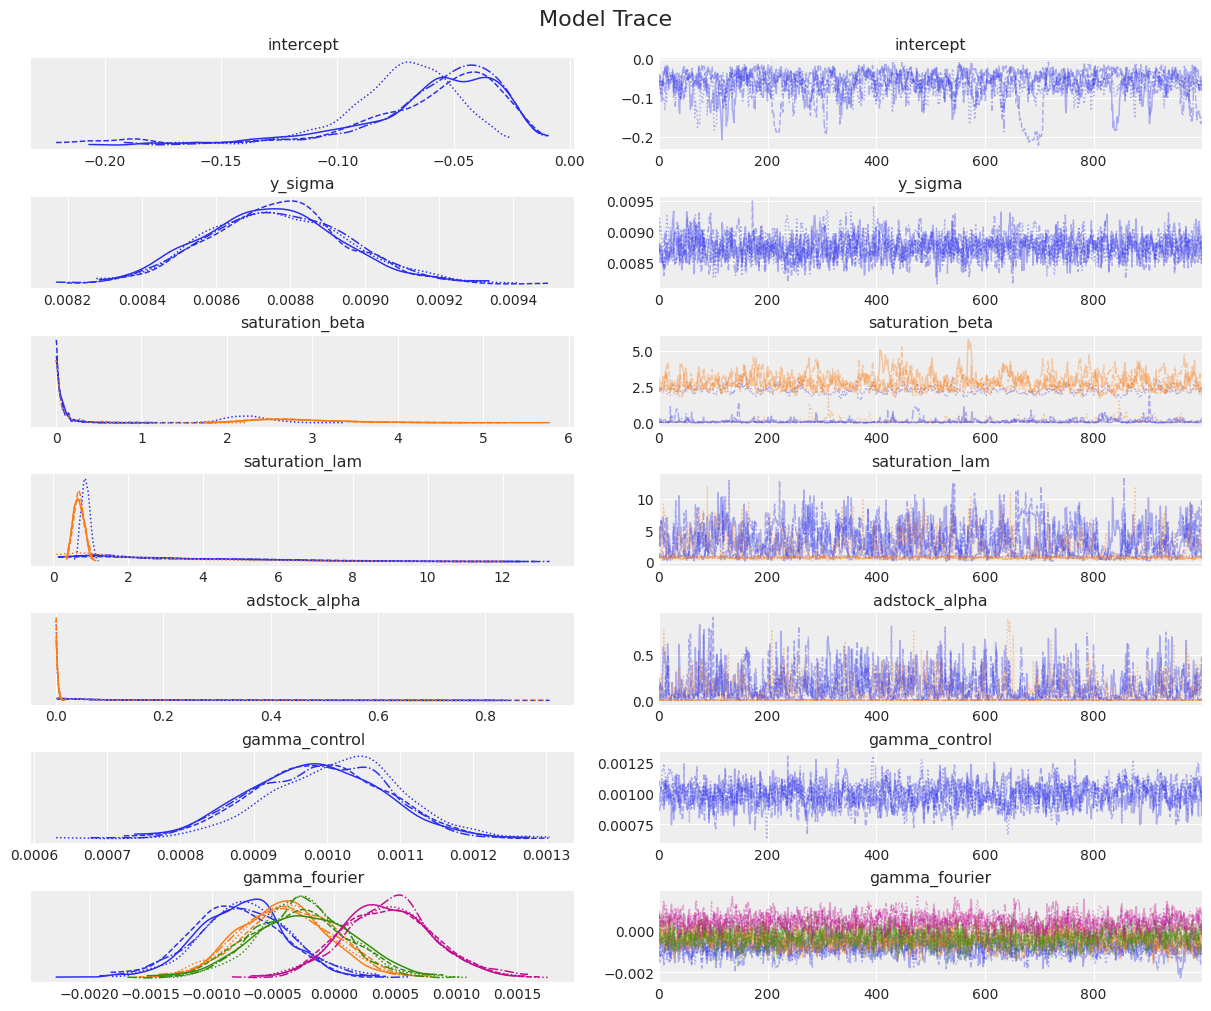

In [63]:
_ = az.plot_trace(
    data=mmm_priors.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

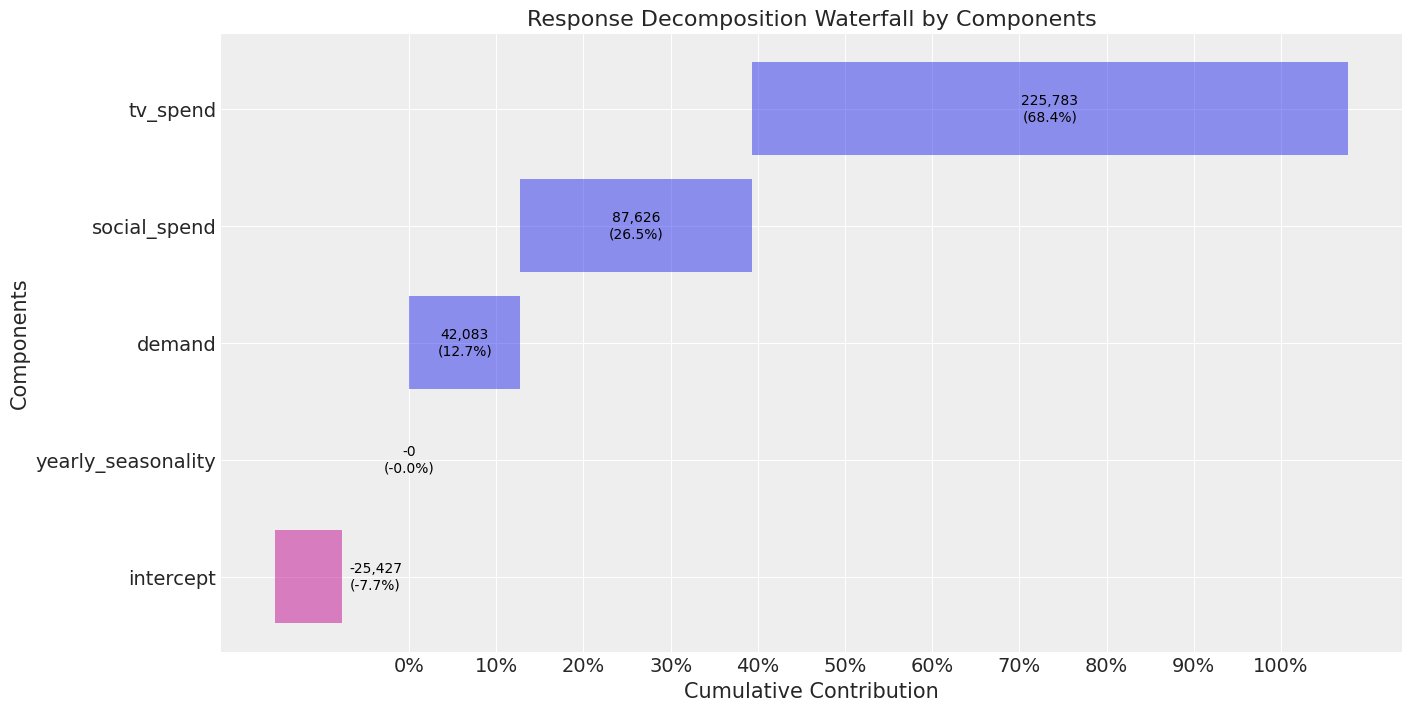

In [64]:
mmm_priors.plot_waterfall_components_decomposition();